# Emoji Prediction - ECS 171 Group Project

### Project Overview

Emojis are widely used for modern communication, and offer a way to express emotions visually. Through computer vision and machine learning, the aim of our project is to be able to predict the emoji that best fits a given facial expression. Since there are many available emojis representing different emotions, to keep our project simple and achievable within the given time constraint, we are going to use just a few: Happy, Sad, and Neutral. If time permits, we will move onto more complex emotions: Angry, Disgust, Fear, and Surprise. Our approach is to use a Convolution Neural Network for facial recognition, and we are going to classify these expressions into a category of emotions. From there, we will simply output the emoji that matches that particular emotion. 

### Description of Dataset

The dataset we are using can be found here. 

There are 4,254 observations in the dataset, with 1774 happy observations, 1233 neutral observations, and 1247 sad observations. Each “observation”, or image file, is a 48x48 pixel sized grayscale image of expressions on faces. Sizes are all standardized to 


### Data Exploration

First, we must explore the data.

i.e. evaluate your data, # of observations, details about your data distributions, scales, missing data, column descriptions) Note: For image data you can still describe your data by the number of classes, # of images, size of images, are sizes standardized? do they need to be cropped? normalized? Etc.


In [17]:
# importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import load_img

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPool2D, Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

In [3]:
! pip install -q kaggle

--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1283, in render
    renderable = rich_cast(renderable)
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/protocol.py", line 36

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/home/sohumgoel/.kaggle’: File exists


In [5]:
! kaggle datasets download -d msambare/fer2013

fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
! unzip fer2013.zip

Archive:  fer2013.zip
replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# Data Evaluation

Goes through the dataset and describes data by defining number of classes, # of images, and size of images. 


In [18]:
train_dir = './train/'
test_dir = './test/'

# image size
row, col = 48, 48
# number of image classes: angry, sad, etc
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

# number of observations
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


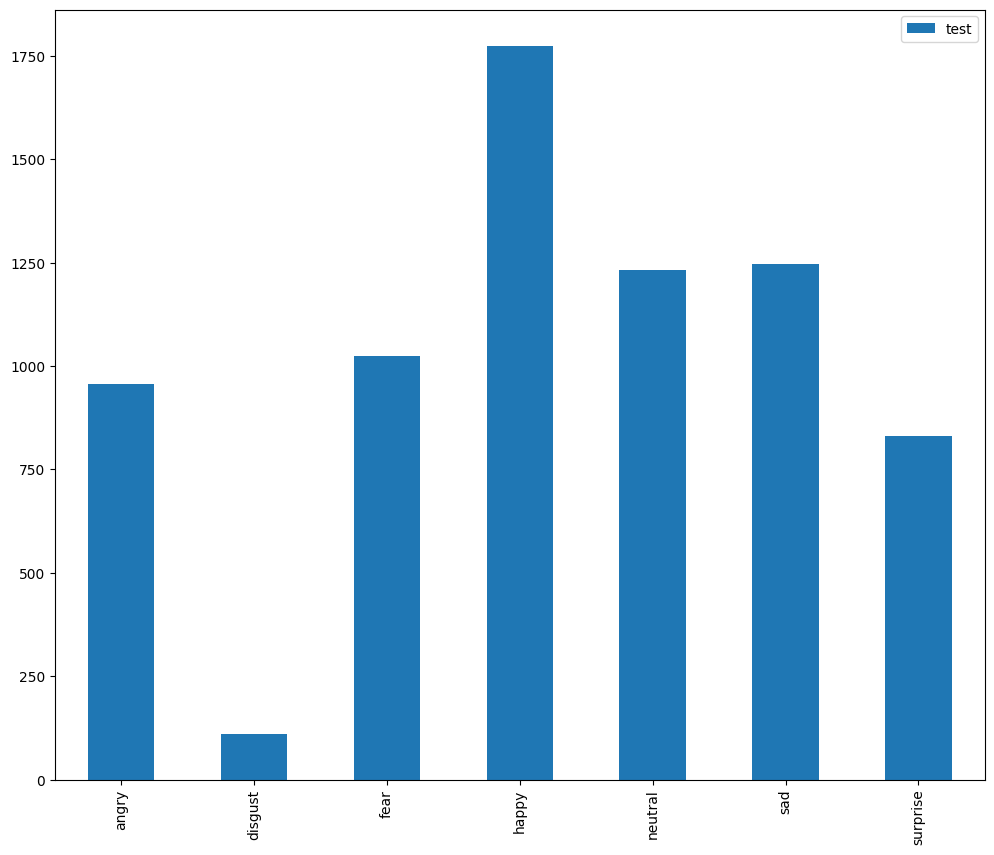

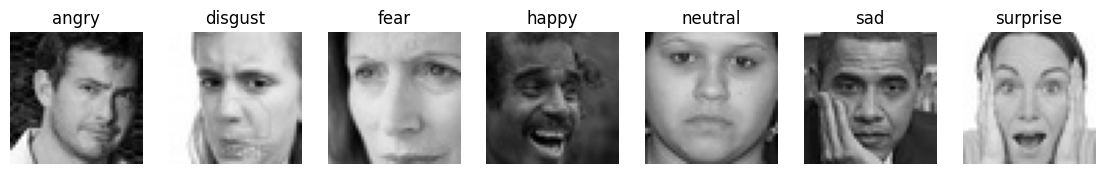

In [19]:
test_count.transpose().plot(kind='bar',figsize=(12, 10))

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fea492ea-45b1-45bc-9b38-4a1d1d39ebc1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

# Data Preprocessing



In [33]:
train = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train.flow_from_directory(
    directory = train_dir, 
    target_size=(48,48), 
    class_mode="categorical", 
    color_mode="grayscale"
)

Found 28709 images belonging to 7 classes.


In [34]:
test = ImageDataGenerator(rescale=1./255)
test_generator = test.flow_from_directory(
    directory = test_dir, 
    target_size=(48,48), 
    class_mode="categorical", 
    color_mode="grayscale"
)

Found 7178 images belonging to 7 classes.


In [35]:
model= tf.keras.models.Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(7, activation='relu'))

model.compile(
    optimizer = Adam(), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [36]:
epochs = 10
batch_size = 64

In [37]:
firstModel = model.fit(x = train_generator, batch_size = 1, epochs = epochs, validation_data = test_generator)

Epoch 1/10
898/898 [==============================] - 41s 45ms/step - loss: 2.0832 - accuracy: 0.3173 - val_loss: 1.9058 - val_accuracy: 0.3373
Epoch 2/10
898/898 [==============================] - 40s 44ms/step - loss: 1.8719 - accuracy: 0.3554 - val_loss: 1.8662 - val_accuracy: 0.3844
Epoch 3/10
898/898 [==============================] - 39s 43ms/step - loss: 1.8741 - accuracy: 0.3519 - val_loss: 1.9240 - val_accuracy: 0.2615
Epoch 4/10
898/898 [==============================] - 39s 43ms/step - loss: 1.8538 - accuracy: 0.3441 - val_loss: 1.8341 - val_accuracy: 0.3923
Epoch 5/10
898/898 [==============================] - 39s 43ms/step - loss: 1.8030 - accuracy: 0.3771 - val_loss: 1.8577 - val_accuracy: 0.3718
Epoch 6/10
898/898 [==============================] - 39s 43ms/step - loss: 1.8213 - accuracy: 0.3744 - val_loss: 1.8958 - val_accuracy: 0.2824
Epoch 7/10
898/898 [==============================] - 39s 44ms/step - loss: 1.8199 - accuracy: 0.3686 - val_loss: 1.8199 - val_accuracy:

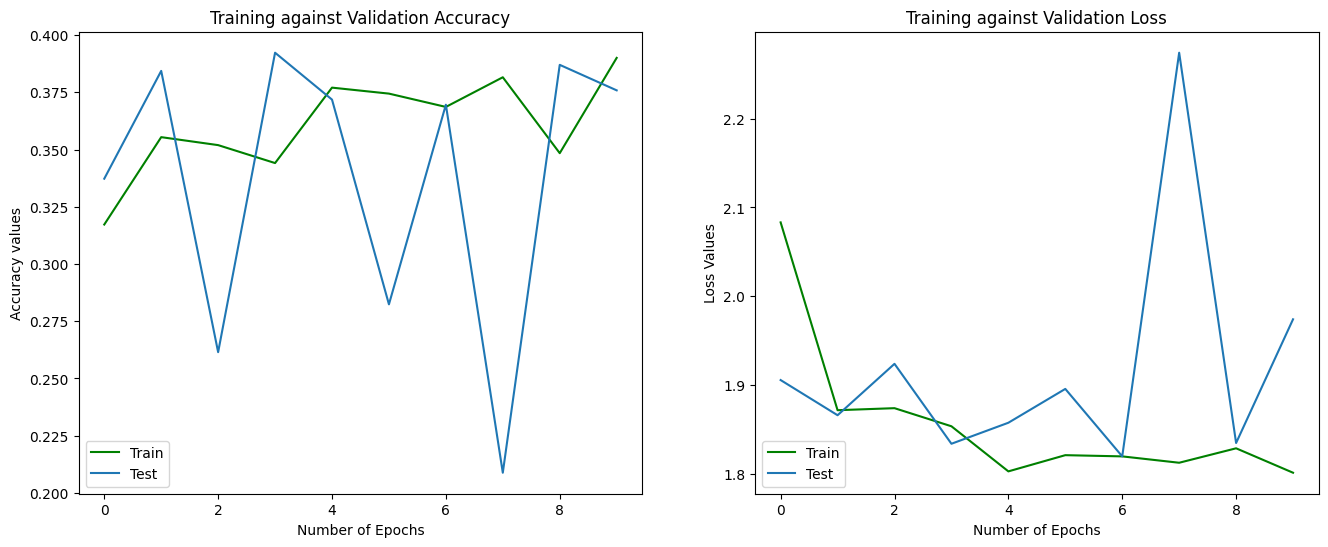

In [38]:
figure, axis = plt.subplots(1,2)
figure.set_size_inches(16,6)

train_ACC = firstModel.history['accuracy']
train_loss = firstModel.history['loss']

axis[0].plot(firstModel.history['accuracy'], color = "green")
axis[0].plot(firstModel.history['val_accuracy'])
axis[0].set_xlabel('Number of Epochs')
axis[0].set_ylabel('Accuracy values')
axis[0].set_title('Training against Validation Accuracy')
axis[0].legend(['Train', 'Test'], loc = 'lower left')

axis[1].plot(firstModel.history['loss'], color = "green")
axis[1].plot(firstModel.history['val_loss'])
axis[1].set_title('Training against Validation Loss')
axis[1].set_xlabel('Number of Epochs')
axis[1].set_ylabel('Loss Values')
axis[1].set_title('Training against Validation Loss')
axis[1].legend(['Train', 'Test'], loc ='lower left')

plt.show()

In [39]:
train_loss, train_ACC = model.evaluate(train_generator)
test_loss, test_ACC   = model.evaluate(test_generator)
print("The accuracy = {:.3f} , test accuracy = {:.3f}".format(train_ACC*100, test_ACC*100))

225/225 [==============================] - 5s 24ms/step - loss: 1.9742 - accuracy: 0.3759
The accuracy = 38.848 , test accuracy = 37.587
